In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statistics
from scipy import stats
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from skimage.metrics import structural_similarity as ssim
from sklearn.manifold import TSNE
import plotly.express as px
import umap

In [307]:
def load_matrix(data, matrix_size=200):
    # Filter interactions within the same chromosome
    data = data[data['chr1'] == data['chr2']]
    # Determine the range of positions
    max_pos = data[['pos1', 'pos2']].max().max()
    min_pos = data[['pos1', 'pos2']].min().min()
    # Define the bin size dynamically based on the desired matrix size
    bin_size = (max_pos - min_pos) / matrix_size
    # Create bins
    bins = np.linspace(min_pos, max_pos, matrix_size + 1)
    # Create a mapping of positions to bins
    data['bin1'] = np.digitize(data['pos1'], bins) - 1
    data['bin2'] = np.digitize(data['pos2'], bins) - 1
    # Ensure bins do not exceed the matrix size
    data['bin1'] = data['bin1'].clip(upper=matrix_size - 1)
    data['bin2'] = data['bin2'].clip(upper=matrix_size - 1)
    # Create unique identifiers for each bin
    data['bin_id1'] = data['chr1'].astype(str) + '_' + data['bin1'].astype(str)
    data['bin_id2'] = data['chr2'].astype(str) + '_' + data['bin2'].astype(str)
    # Get unique bins
    unique_bins = np.unique(np.concatenate([data['bin_id1'], data['bin_id2']]))
    # Initialize the contact matrix
    contact_matrix = np.zeros((matrix_size, matrix_size))
    # Populate the contact matrix
    for _, row in data.iterrows():
        idx1 = row['bin1']
        idx2 = row['bin2']
        contact_matrix[idx1, idx2] += row['interaction']
        contact_matrix[idx2, idx1] += row['interaction']  # Assuming symmetry
    
    return contact_matrix

# Function to load all the matrices in a directory
def load_matrices(directory, contact_matrices, filepaths):
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            # matrix = load_contact_matrix(filepath)
            matrix = load_matrix(pd.read_csv(filepath, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction']))
            contact_matrices.append(matrix)
            filepaths.append(filepath)
        

def plot_matrices(num_matrices, matrices_per_figure, contact_matrices):
    for start in range(0, num_matrices, matrices_per_figure):
        end = min(start + matrices_per_figure, num_matrices)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if start + i < end:
            matrix = contact_matrices[start + i]
            im = ax.imshow(matrix, cmap='coolwarm', interpolation='none')
            ax.set_title(f'Matrix {start + i + 1}')
            ax.set_xlabel('Position along Chromosome')
            ax.set_ylabel('Position along Chromosome')
            fig.colorbar(im, ax=ax, label='Interaction Frequency')
        else:
            fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()
    

def find_average(contact_matrices):
    average_list = []
    for matrix in contact_matrices:
        sum = 0
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                sum += matrix[i][j]
        avg = sum / (matrix.shape[0] * matrix.shape[1])
        average_list.append(avg)
    return average_list

def find_average_instance(matrix):
    sum = 0
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            sum += matrix[i][j]
    return sum / (matrix.shape[0] * matrix.shape[1])

def matrix_avg_stats(average_list):
    avg = statistics.mean(average_list)
    sd = statistics.stdev(average_list)
    minimum = min(average_list)
    maximum = max(average_list)
    n = len(average_list)
    return {"average": avg, "standard deviation": sd, "minimum": minimum, "maximum": maximum, "count": n}

def find_max_shape_matrix(genotype: str) -> str:
    addr = ""
    max = (0, 0)
    for file in os.listdir(genotype):
        filepath = os.path.join(genotype, file)
        full = pd.read_csv(filepath, sep='\t', header=None)
        full.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
        # Find unique values in column 2 (pos1) and column 4 (pos2)
        full_posx = full['pos1'].unique()
        full_posy = full['pos2'].unique()
        if len(full_posx) > max[0] and len(full_posy) > max[1]:
            max = (len(full_posx), len(full_posy))
            addr = filepath

    return addr

def augment(genotype:str, filepaths:list[str]) -> list[pd.DataFrame]:
    """
    genotype: str, the genotype directory, eg. "./GM12878"
    filepaths: list[str], the list of filepaths of the matrices in the genotype directory
    """
    augmented_matrices = [] # Stores all augmented matrices

    max_size_file_path = find_max_shape_matrix(genotype)

    # Find the reference axes
    reference_data = pd.read_csv(max_size_file_path, sep='\t', header=None)
    # Assign column names
    reference_data.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
    # Find unique values in column 2 (pos1) and column 4 (pos2)
    unique_posx = reference_data['pos1'].unique()
    unique_posy = reference_data['pos2'].unique()

    # Find all (200, 200) full matrices
    full_matrices_dir = []
    for file in os.listdir(genotype):
        filepath = os.path.join(genotype, file)
        if os.path.isfile(filepath):
            matrix = load_matrix(pd.read_csv(filepath, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction']))
            if matrix.shape == (200, 200):
                full_matrices_dir.append(filepath)
                augmented_matrices.append(matrix)

    # Find all matrices that are not 200x200
    not_full_matrices = []
    for filepath in filepaths:
        if filepath not in full_matrices_dir:
            not_full_matrices.append(filepath)

    for filepath in not_full_matrices:
        temp_data = pd.read_csv(filepath, sep='\t', header=None)
        temp_data.columns = ['chr1', 'pos1', 'chr2', 'pos2', 'interaction']
        temp_x = temp_data['pos1'].unique()
        temp_y = temp_data['pos2'].unique()
        matrix = load_matrix(pd.read_csv(filepath, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction']))
        diff_x = np.setdiff1d(unique_posx, temp_x)  # columns missing
        diff_y = np.setdiff1d(unique_posy, temp_y)  # rows missing
        missing_data = reference_data[reference_data['pos1'].isin(diff_x) | reference_data['pos2'].isin(diff_y)]
        aug_data = pd.concat([temp_data, missing_data], ignore_index=True)
        aug_matrix = load_matrix(aug_data)
        augmented_matrices.append(aug_matrix)
    return augmented_matrices

def visualize(matrix, vmax) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix, cmap='coolwarm', interpolation='none', vmin=0, vmax=vmax)
    plt.colorbar()
    plt.title('Contact Matrix')
    plt.xlabel('Position Bin')
    plt.ylabel('Position Bin')
    plt.show()

def calculate_contact_probability(matrix):
    size = matrix.shape[0]
    probabilities = np.zeros(size)
    
    for d in range(size):
        contact_sum = 0
        count = 0
        for i in range(size - d):
            contact_sum += matrix[i, i + d]
            count += 1
        if count > 0:
            probabilities[d] = contact_sum / count
        else:
            probabilities[d] = 0
    
    return probabilities

def contact_probability_distance(matrix1, matrix2):
    # Calculate contact probabilities
    probabilities1 = calculate_contact_probability(matrix1)
    probabilities2 = calculate_contact_probability(matrix2)
    
    # Calculate the Euclidean distance between the two probability distributions
    distance = euclidean(probabilities1, probabilities2)
    return distance

def compare_matrices_with_windows(matrix1, matrix2, window_size=20):
    matrix_size = matrix1.shape[0]
    result_size = matrix_size // window_size
    result_matrix = np.zeros((result_size, result_size))
    
    for i in tqdm(range(result_size)):
        for j in range(result_size):
            window1 = matrix1[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
            window2 = matrix2[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size]
            distance = mean_absolute_error(window1, window2)
            result_matrix[i, j] = distance
            
    return result_matrix

def sum_of_squared_differences(matrix1, matrix2):
    return round(np.sum((matrix1 - matrix2) ** 2), 3)

def mean_absolute_error(matrix1, matrix2):
    return np.mean(np.abs(matrix1 - matrix2))

## Analysis for GM12878

In [222]:
# Directory containing the data files
directory = './GM12878'

In [223]:
# Load all contact matrices into a list
contact_matrices_GM12878 = []
filepaths_GM12878 = []

In [224]:
load_matrices(directory, contact_matrices_GM12878, filepaths_GM12878)

num_matrices = len(contact_matrices_GM12878)

print(num_matrices)


24


In [225]:
augmented_matrices_GM12878 = augment(directory, filepaths_GM12878)

In [227]:
average_GM12878 = find_average(augmented_matrices_GM12878)

average_stats_GM12878 = matrix_avg_stats(average_GM12878)

print(average_GM12878)
print(average_stats_GM12878)

[0.1385, 0.5895, 0.2072, 0.2917, 0.23205, 0.22035, 0.20465, 0.2813, 0.15575, 0.38065, 0.1954, 0.1578, 0.39975, 0.3859, 0.6475, 0.512, 0.27535, 0.3588, 0.28975, 0.2385, 0.2219, 0.4617, 0.255, 0.12935]
{'average': 0.30126458333333334, 'standard deviation': 0.14015308282697814, 'minimum': 0.12935, 'maximum': 0.6475, 'count': 24}


## Analysis for HAP1

In [228]:
directory = './HAP1'

# Load all contact matrices into a list
contact_matrices_HAP1 = []
filepaths_HAP1 = []

# Load in the contact matrices from txt files
load_matrices(directory, contact_matrices_HAP1, filepaths_HAP1)


num_matrices = len(contact_matrices_HAP1)

augmented_matrices_HAP1 = augment(directory, filepaths_HAP1)


average_HAP1 = find_average(augmented_matrices_HAP1)

average_stats_HAP1 = matrix_avg_stats(average_HAP1)

## Analysis for Hela

In [229]:
directory = './Hela'

# Load all contact matrices into a list
contact_matrices_Hela = []
filepaths_Hela = []

# Load in the contact matrices from txt files
load_matrices(directory, contact_matrices_Hela, filepaths_Hela)


num_matrices = len(contact_matrices_Hela)

augmented_matrices_Hela = augment(directory, filepaths_Hela)


average_Hela = find_average(augmented_matrices_Hela)

average_stats_Hela = matrix_avg_stats(average_Hela)

In [230]:
directory = './K562'

# Load all contact matrices into a list
contact_matrices_K562 = []
filepaths_K562 = []

# Load in the contact matrices from txt files
load_matrices(directory, contact_matrices_K562, filepaths_K562)


num_matrices = len(contact_matrices_K562)

augmented_matrices_K562 = augment(directory, filepaths_K562)


average_K562 = find_average(augmented_matrices_K562)

average_stats_K562 = matrix_avg_stats(average_K562)

In [231]:
# Hypothesis testing:
# Null hypothesis: The given average belongs to the distribution.
avg_to_test = find_average_instance(augmented_matrices_GM12878[0])

t_statistic, p_value = stats.ttest_1samp(average_Hela, avg_to_test)

# Print the test statistic and p-value
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.0001

# Conclusion
if p_value < alpha:
    print("Reject the null hypothesis: The given average does not belong to the distribution.")
else:
    print("Fail to reject the null hypothesis: The given average belongs to the distribution.")
    


T-statistic: 31.26301283866879
P-value: 2.642582216134433e-168
Reject the null hypothesis: The given average does not belong to the distribution.


In [232]:
print("GM12878 statistics:", average_stats_GM12878)
print("GM12878 averages:", average_GM12878)
print("avg of avg:", sum(average_GM12878) / len(average_GM12878))
print("====================================================")
print("HAP1 statistics:", average_stats_HAP1)
print("HAP1 averages:", average_HAP1)
print("avg of avg:", sum(average_HAP1) / len(average_HAP1))
print("====================================================")
print("Hela statistics:", average_stats_Hela)
print("Hela averages:", average_Hela)
print("avg of avg:", sum(average_Hela) / len(average_Hela))
print("====================================================")
print("K562 statistics:", average_stats_K562)
print("K562 averages:", average_K562)
print("avg of avg:", sum(average_K562) / len(average_K562))

GM12878 statistics: {'average': 0.30126458333333334, 'standard deviation': 0.14015308282697814, 'minimum': 0.12935, 'maximum': 0.6475, 'count': 24}
GM12878 averages: [0.1385, 0.5895, 0.2072, 0.2917, 0.23205, 0.22035, 0.20465, 0.2813, 0.15575, 0.38065, 0.1954, 0.1578, 0.39975, 0.3859, 0.6475, 0.512, 0.27535, 0.3588, 0.28975, 0.2385, 0.2219, 0.4617, 0.255, 0.12935]
avg of avg: 0.30126458333333334
HAP1 statistics: {'average': 0.8634691384950927, 'standard deviation': 1.0761062484685395, 'minimum': 0.102, 'maximum': 12.14155, 'count': 917}
HAP1 averages: [0.29025, 0.91405, 0.2664, 0.3565, 0.54305, 0.1639, 0.4139, 3.2651, 1.5391, 0.1567, 0.17495, 0.69045, 0.94085, 1.76485, 1.2097, 0.56815, 0.24, 0.72615, 1.2428, 1.29285, 0.14485, 0.53305, 0.38885, 0.42985, 2.2599, 0.2173, 0.16665, 1.67235, 0.22895, 0.12225, 0.2983, 0.94715, 0.50325, 0.15785, 1.70065, 0.76065, 2.07605, 0.2723, 0.5516, 0.7167, 1.0626, 1.85465, 0.8058, 0.737, 0.8994, 1.47645, 2.1529, 0.618, 0.214, 1.09375, 2.13435, 0.3798, 0.2

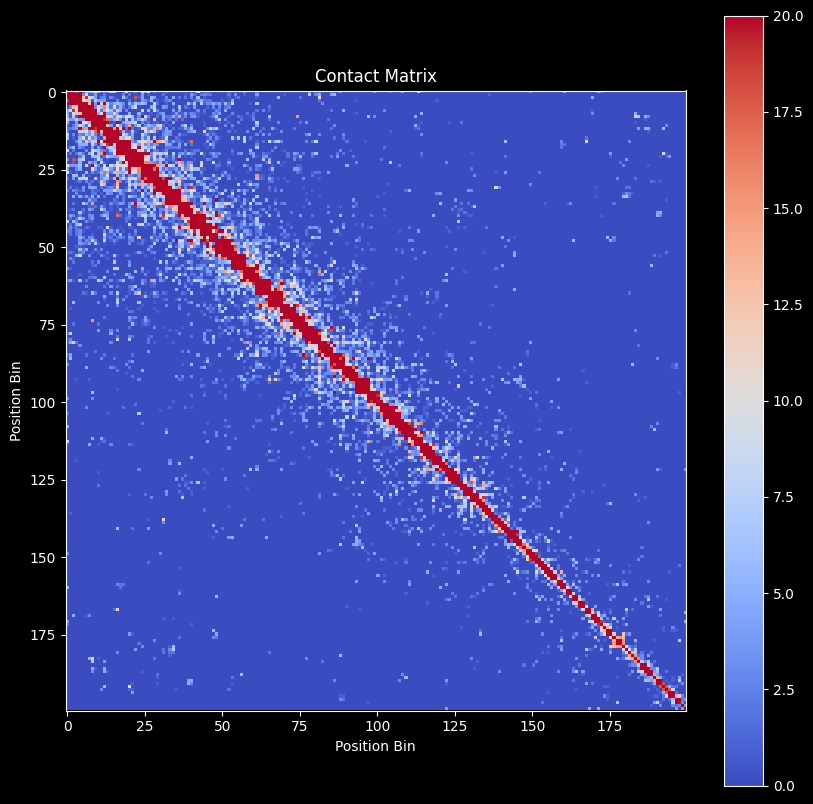

In [243]:
visualize(augmented_matrices_Hela[2], 20)

100%|██████████| 10/10 [00:00<00:00, 1923.73it/s]


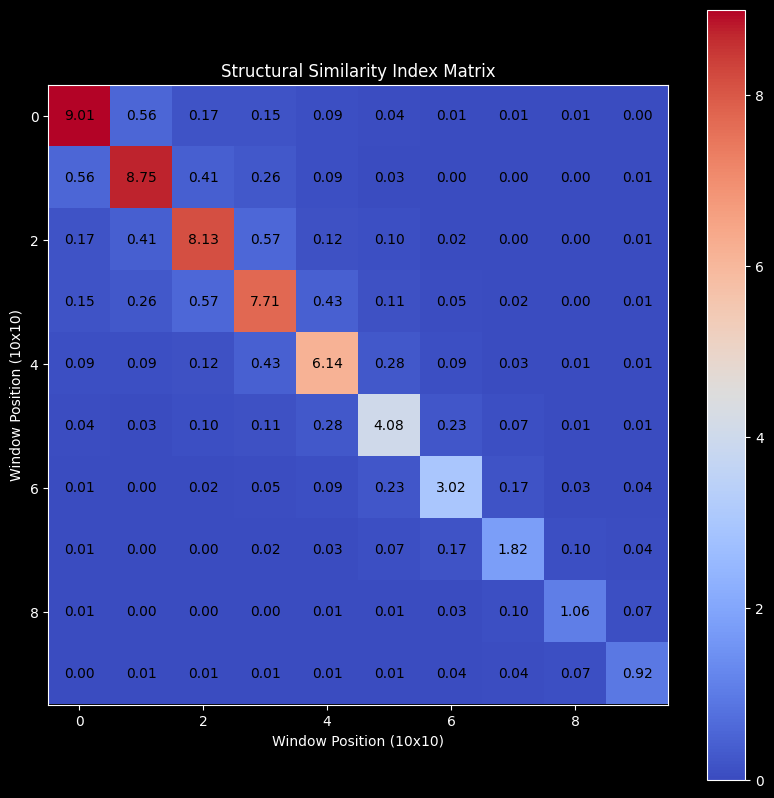

In [311]:
matrix_size = 200
window_size = 20


result = compare_matrices_with_windows(augmented_matrices_GM12878[0], augmented_matrices_Hela[1], window_size=20)


# Plot the result matrix
plt.figure(figsize=(10, 10))
plt.imshow(result, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Structural Similarity Index Matrix')
plt.xlabel('Window Position (10x10)')
plt.ylabel('Window Position (10x10)')

# Annotate the heatmap with the distance values
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        plt.text(j, i, f'{result[i, j]:.2f}', ha='center', va='center', color='black')

plt.show()

In [330]:
# Function to flatten matrices
def flatten_matrices(matrices):
    return [matrix.flatten() for matrix in matrices]

flattened_GM12878 = flatten_matrices(augmented_matrices_GM12878)
flattened_HAP1 = flatten_matrices(augmented_matrices_HAP1)
flattened_Hela = flatten_matrices(augmented_matrices_Hela)
flattened_K562 = flatten_matrices(augmented_matrices_K562)

all_matrices = flattened_GM12878 + flattened_HAP1 + flattened_Hela + flattened_K562
labels = (
    [1] * len(flattened_GM12878) +
    [2] * len(flattened_HAP1) +
    [3] * len(flattened_Hela) +
    [4] * len(flattened_K562)
)
all_matrices = np.array(all_matrices)
labels = np.array(labels)
# Apply t-SNE
tsne = TSNE(n_components=3, perplexity=50, learning_rate=100, random_state=42)
tsne_results = tsne.fit_transform(all_matrices)

# Create a scatter plot of the t-SNE results
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2', 'TSNE3'])
df_tsne['Label'] = labels

# Plot the 3D t-SNE results using plotly
fig = px.scatter_3d(
    df_tsne, x='TSNE1', y='TSNE2', z='TSNE3',
    color=df_tsne['Label'].astype(str),  # Convert labels to string for better color differentiation
    title='3D t-SNE Visualization of Cell Line Clusters',
    labels={'color': 'Cell Line'}
)

fig.show()

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity (Elena)/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



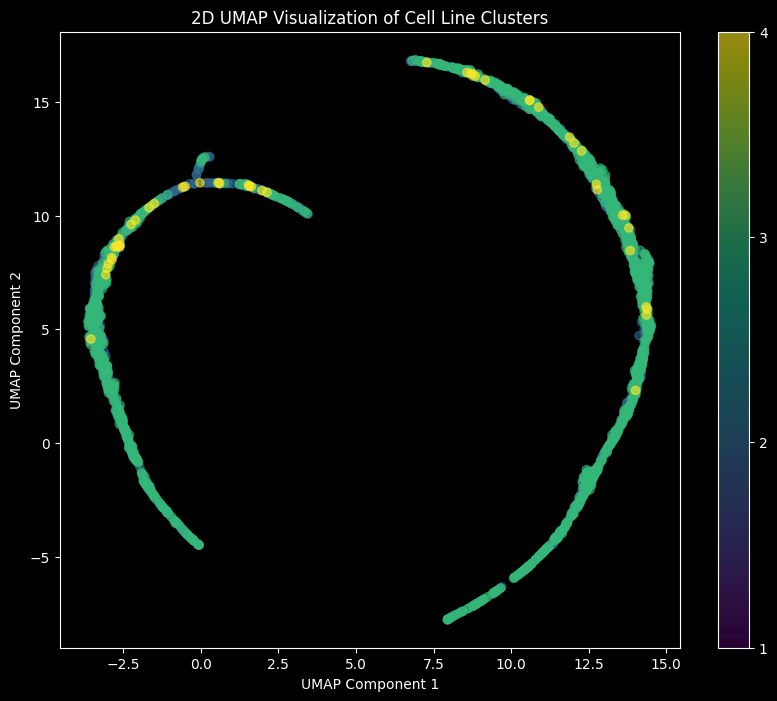

In [334]:
# Convert to NumPy arrays and ensure correct data types
all_matrices = np.array(all_matrices).astype(np.float64)
labels = np.array(labels).astype(np.int64)

# Apply UMAP with 2 components
umap_2d = umap.UMAP(n_components=2, random_state=42)
umap_results_2d = umap_2d.fit_transform(all_matrices)

# 2D Visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_results_2d[:, 0], umap_results_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=[1, 2, 3, 4])
plt.title('2D UMAP Visualization of Cell Line Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

In [335]:
# Apply UMAP with 3 components
umap_3d = umap.UMAP(n_components=3, random_state=42)
umap_results_3d = umap_3d.fit_transform(all_matrices)

# 3D Visualization
df_umap_3d = pd.DataFrame(umap_results_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_umap_3d['Label'] = labels

fig = px.scatter_3d(
    df_umap_3d, x='UMAP1', y='UMAP2', z='UMAP3',
    color=df_umap_3d['Label'].astype(str),
    title='3D UMAP Visualization of Cell Line Clusters',
    labels={'color': 'Cell Line'}
)

fig.show()

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity (Elena)/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

